In [1]:
import sys
import spotipy
import yaml
import spotipy.util as util
from pprint import pprint
import json
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import plotly.graph_objects as go
# from yellowbrick.cluster import KElbowVisualizer
# from kneed import KneeLocator
from plotly.subplots import make_subplots
import networkx as nx
import mpld3
mpld3.enable_notebook()
sns.set()

## Spotipy Credentials and API Calls

In [2]:
# Get Spotipy credentials from config
def load_config():
    stream = open('config.yaml')
    user_config = yaml.load(stream, Loader=yaml.FullLoader)
    return user_config

user_config = load_config()

In [3]:
# Initialize Spotify API token
def get_token(SCOPE):
    token = util.prompt_for_user_token(user_config['username'], scope=SCOPE, client_id=user_config['client_id'], client_secret=user_config['client_secret'], redirect_uri=user_config['redirect_uri'])
    return token

In [4]:
def treat_nans(df):
    for col in df.columns[3:]:
        df[col] = df[col].fillna(value=df[col].mean())
    return df

In [5]:
# A function to extract track names and URIs from a playlist
def get_playlist_info(username, playlist_uri):
    # initialize vars
    offset = 0
    tracks, uris, names, artists = [], [], [], []

    # get playlist id and name from URI
    playlist_id = playlist_uri.split(':')[2]
    playlist_name = sp.user_playlist(username, playlist_id)['name']

    # get all tracks in given playlist (max limit is 100 at a time --> use offset)
    while True:
        results = sp.user_playlist_tracks(username, playlist_id, offset=offset)
        tracks += results['items']
        if results['next'] is not None:
            offset += 100
        else:
            break
        
    # get track metadata
    for track in tracks:
        names.append(track['track']['name'])
        artists.append(track['track']['artists'][0]['name'])
        uris.append(track['track']['uri'])
    
    return playlist_name, names, artists, uris

In [6]:
# Extract features from each track in a playlist
def get_features_for_playlist(df, username, uri):
  
    # get all track metadata from given playlist
    playlist_name, names, artists, uris = get_playlist_info(username, uri)
    
    # iterate through each track to get audio features and save data into dataframe
    for name, artist, track_uri in zip(names, artists, uris):
        # print(json.dumps(track_uri, indent=4))              
        # ^ DEBUG STATEMENT ^
        
        # access audio features for given track URI via spotipy 
        audio_features = sp.audio_features(track_uri)

        # get relevant audio features
        feature_subset = [audio_features[0][col] for col in df.columns if col not in ["track_name", "artist", "track_URI"]]

        # compose a row of the dataframe by flattening the list of audio features
        row = [name, artist, track_uri, *feature_subset]
        df.loc[len(df.index)] = row
    return df

In [18]:
sp = spotipy.Spotify(auth=get_token('user-top-read'))

G = nx.Graph()

df = pd.DataFrame(columns=['track_name', 'artist', 'track_URI', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'mode', 'loudness', 'speechiness', 'tempo', 'valence'])

top_artists = [x for x in sp.current_user_top_artists(limit=10, time_range='short_term')['items']]
artist_queue=[*top_artists]
print(artist_queue[0])
G.add_nodes_from([('ME', dict(size=100))])
G.add_nodes_from([(artist['name'], dict(size=artist['popularity'])) for artist in artist_queue])
G.add_edges_from([('ME', artist['name']) for artist in artist_queue])

while len(df) < 1000 and artist_queue:
        artist = artist_queue.pop(0)
        if artist['name'] in df['artist'].unique():
                continue
        related_artists = sp.artist_related_artists(artist['uri'])['artists'][:10]
        artist_queue.extend(related_artists)
        G.add_nodes_from([(ra['name'], dict(size=ra['popularity'])) for ra in related_artists])
        G.add_edges_from([(artist['name'], ra['name']) for ra in related_artists])
        artist_top_tracks = sp.artist_top_tracks(artist['uri'])
        for track in artist_top_tracks['tracks'][:10]:
                track_name = track['name']
                artist = track['artists'][0]['name']
                track_uri = track['uri']
                
                # access audio features for given track URI via spotipy
                audio_features = sp.audio_features(track_uri)
                
                # get relevant audio features
                feature_subset = [audio_features[0][col] for col in df.columns if col not in ["track_name", "artist", "track_URI"]]

                # compose a row of the dataframe by flattening the list of audio features
                row = [track_name, artist, track_uri, *feature_subset]
                df.loc[len(df.index)] = row

df = treat_nans(df)
df

{'external_urls': {'spotify': 'https://open.spotify.com/artist/4gzpq5DPGxSnKTe4SA8HAU'}, 'followers': {'href': None, 'total': 32195713}, 'genres': ['permanent wave', 'pop'], 'href': 'https://api.spotify.com/v1/artists/4gzpq5DPGxSnKTe4SA8HAU', 'id': '4gzpq5DPGxSnKTe4SA8HAU', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/ab6761610000e5eb865a3301762a8fce048cb469', 'width': 640}, {'height': 320, 'url': 'https://i.scdn.co/image/ab67616100005174865a3301762a8fce048cb469', 'width': 320}, {'height': 160, 'url': 'https://i.scdn.co/image/ab6761610000f178865a3301762a8fce048cb469', 'width': 160}], 'name': 'Coldplay', 'popularity': 91, 'type': 'artist', 'uri': 'spotify:artist:4gzpq5DPGxSnKTe4SA8HAU'}


,track_name,artist,track_URI,acousticness,danceability,energy,instrumentalness,key,liveness,mode,loudness,speechiness,tempo,valence
0,My Universe,Coldplay,spotify:track:46HNZY1i7O6jwTA7Slo2PI,0.01140,0.573,0.711,0.000000,1,0.328,0,-6.268,0.0406,105.006,0.470
1,Yellow,Coldplay,spotify:track:3AJwUDP919kvQ9QcozQPxg,0.00239,0.429,0.661,0.000121,11,0.234,1,-7.227,0.0281,173.372,0.285
2,The Scientist,Coldplay,spotify:track:75JFxkI2RXiU7L9VXzMkle,0.73100,0.557,0.442,0.000015,5,0.110,1,-7.224,0.0243,146.277,0.213
3,Something Just Like This,The Chainsmokers,spotify:track:6RUKPb4LETWmmr3iAEQktW,0.04980,0.617,0.635,0.000014,11,0.164,0,-6.769,0.0317,103.019,0.446
4,Fix You,Coldplay,spotify:track:7LVHVU3tWfcxj5aiPFEW4Q,0.16400,0.209,0.417,0.001960,3,0.113,1,-8.740,0.0338,138.178,0.124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,Do I Fit In Your Shoes?,BabyJake,spotify:track:5icShTlF1tVIkGIGGrzVaK,0.28300,0.704,0.388,0.000000,10,0.176,0,-9.407,0.3490,175.900,0.620
1005,You Do You,Dillon Francis,spotify:track:0Nek8bANm0dzO0vI9mmnJG,0.01030,0.913,0.656,0.059000,7,0.148,1,-6.760,0.0608,119.990,0.421
1006,239,BabyJake,spotify:track:5qTL0KYAVSuLhcUyJYu3jV,0.05940,0.783,0.569,0.000031,9,0.101,1,-7.891,0.1180,160.055,0.747
1007,My Anxiety,BabyJake,spotify:track:0q0Jgj7gvnMLSoCvZjpdSm,0.26600,0.904,0.559,0.000113,10,0.103,0,-7.410,0.0408,116.038,0.668


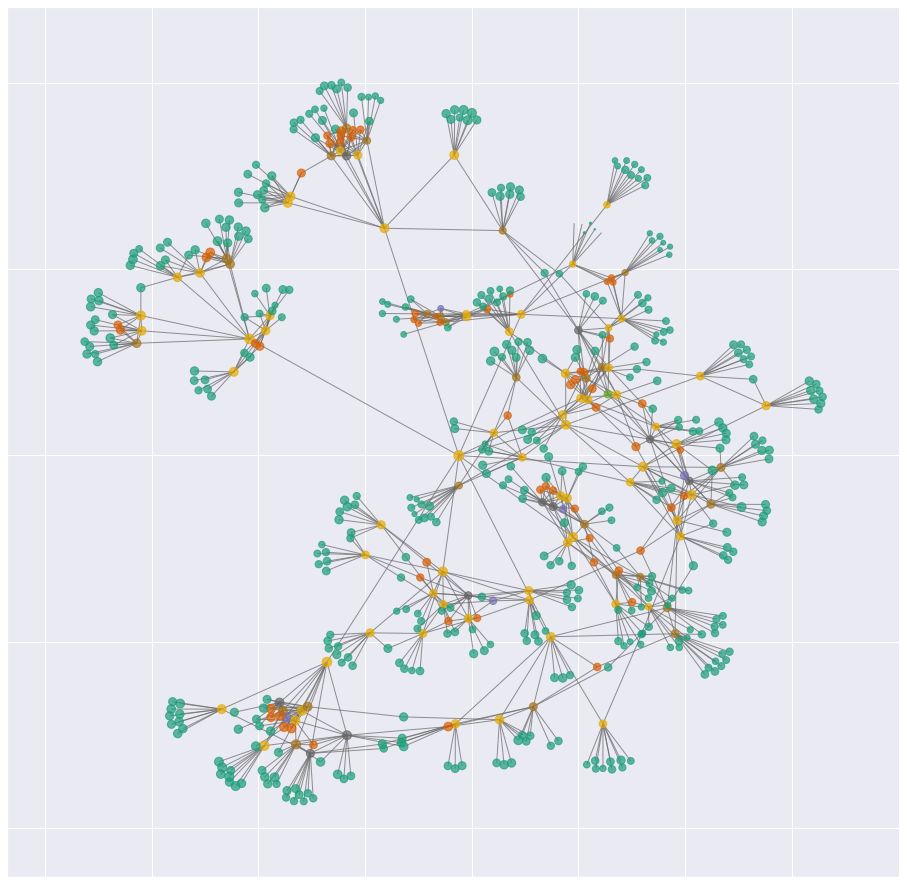

In [26]:
plt.figure(figsize=(16,16))
node_color = [G.degree(v) for v in G]
node_size = [nx.get_node_attributes(G, 'size')[v] for v in G]
pos=nx.circular_layout(G)
nx.draw_networkx(G, node_color=node_color, node_size=node_size, alpha=0.7, with_labels=False, cmap=plt.cm.Dark2, edge_color='.4')


In [79]:
my_songs_df = pd.DataFrame(columns=['track_name', 'artist', 'track_URI', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'mode', 'loudness', 'speechiness', 'tempo', 'valence'])

sp = spotipy.Spotify(auth=get_token('user-read-recently-played'))
recent_tracks = [x['track'] for x in sp.current_user_recently_played()['items']]

for track in recent_tracks:
    track_name = track['name']
    artist = track['artists'][0]['name']
    track_uri = track['uri']
    
    # access audio features for given track URI via spotipy
    audio_features = sp.audio_features(track_uri)
    
    # get relevant audio features
    feature_subset = [audio_features[0][col] for col in my_songs_df.columns if col not in ["track_name", "artist", "track_URI"]]

    # compose a row of the dataframe by flattening the list of audio features
    row = [track_name, artist, track_uri, *feature_subset]
    my_songs_df.loc[len(my_songs_df.index)] = row

my_songs_df = treat_nans(my_songs_df)
my_songs_df

,track_name,artist,track_URI,acousticness,danceability,energy,instrumentalness,key,liveness,mode,loudness,speechiness,tempo,valence
0,♾,Coldplay,spotify:track:2wleRXcIPqltoDPLMH5WDa,0.009410,0.5760,0.8960,0.955000,2,0.1530,1,-8.994,0.0412,135.010,0.4120
1,❤️,Coldplay,spotify:track:3oTYv0yShT4sjuPncoUXfK,0.970000,0.3480,0.0491,0.000186,4,0.0918,1,-15.431,0.0404,136.680,0.2320
2,🌎,Coldplay,spotify:track:0RbekAlUrwR6ZWJdwB3V4y,0.969000,0.1150,0.9070,0.981000,3,0.9800,1,-20.358,0.2230,189.885,0.0185
3,People of The Pride,Coldplay,spotify:track:5ophZLHA9mwSZhQSmboyDN,0.005810,0.4320,0.6130,0.015100,4,0.3120,0,-6.785,0.0349,136.362,0.0911
4,Humankind,Coldplay,spotify:track:23BO6YozrAXUta1buxFZ80,0.000172,0.5750,0.8380,0.000103,2,0.4580,1,-6.498,0.0454,135.006,0.2150
5,Let Somebody Go,Coldplay,spotify:track:4cGqn0E8JCSY9gQllQj4Mf,0.193000,0.5920,0.3420,0.002450,0,0.1100,1,-8.930,0.0339,130.953,0.1550
6,✨,Coldplay,spotify:track:1danObd53GynoY83wRz3Ua,0.805000,0.0859,0.2890,0.990000,5,0.1410,0,-17.240,0.0359,166.784,0.0380
7,Biutyful,Coldplay,spotify:track:2L2mM3rEO3arNIMQnb3dou,0.016800,0.6140,0.6800,0.000560,5,0.1180,0,-7.840,0.0425,153.937,0.3470
8,🪐,Coldplay,spotify:track:1a3G9SNslcKsPAOuIikaxd,0.887000,0.3260,0.3220,0.841000,5,0.1160,1,-20.192,0.0337,89.657,0.0651
9,My Universe,Coldplay,spotify:track:46HNZY1i7O6jwTA7Slo2PI,0.008130,0.5880,0.7010,0.000000,9,0.2000,1,-6.390,0.0402,104.988,0.4430


In [100]:
sp = spotipy.Spotify(auth=get_token('playlist-read-private'))

playlist_df = pd.DataFrame(columns=['track_name', 'artist', 'track_URI', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'mode', 'loudness', 'speechiness', 'tempo', 'valence'])

playlist_df = get_features_for_playlist(playlist_df, user_config['username'], 'spotify:playlist:5hvgiq3c8IFnaBgbwDcttd')

playlist_df = treat_nans(playlist_df)
playlist_df


,track_name,artist,track_URI,acousticness,danceability,energy,instrumentalness,key,liveness,mode,loudness,speechiness,tempo,valence
0,Settle,Two Door Cinema Club,spotify:track:7rOneF5Ox2DarSh4557VXX,0.00647,0.487,0.775,0.061400,0,0.0893,1,-5.877,0.0375,131.862,0.163
1,Punching In A Dream,The Naked And Famous,spotify:track:5PtEpuVX03k9bOUwilL5EO,0.00201,0.473,0.883,0.000967,6,0.1420,1,-3.650,0.0470,115.048,0.164
2,Jubel - Nora En Pure Remix,Klingande,spotify:track:0UmBBoADlU9Vy7irHCKseL,0.00287,0.743,0.766,0.456000,0,0.0917,1,-5.401,0.0326,124.993,0.625
3,higher,pluko,spotify:track:5Rddx0DkGh79Lq0TfZ9GiW,0.03920,0.624,0.568,0.000256,1,0.1290,1,-8.905,0.0591,91.009,0.282
4,Die For It (ft. Nas),Belly,spotify:track:3JvdrCezbM6DQOjNiBiX5q,0.37100,0.689,0.487,0.000000,5,0.4280,0,-9.585,0.0791,97.043,0.215
5,Moonwalk,Rexx Life Raj,spotify:track:0bJQ2EJndGgy6gN63wSHty,0.41100,0.706,0.480,0.000000,0,0.1030,1,-10.421,0.2980,75.050,0.682
6,Your Way,Rexx Life Raj,spotify:track:5sc7JPdQFdWiwyZtl2kjal,0.63000,0.718,0.328,0.000000,3,0.1050,0,-10.958,0.0302,99.966,0.720
7,One Man Can Change The World,Big Sean,spotify:track:731Pa6Gt7GAdADATMSEL0N,0.77700,0.670,0.580,0.000000,8,0.1100,0,-6.586,0.1440,157.997,0.309
8,cbb to b sad,IDER,spotify:track:56b4sQ1Sxi3ox5CoCmcp49,0.30400,0.705,0.765,0.000766,0,0.1380,1,-8.246,0.0772,101.988,0.714
9,Lighter (with Tarrus Riley & Rvssian),Shenseea,spotify:track:1AAkIj1NSdpaoOZYctGnrg,0.16200,0.521,0.682,0.000000,1,0.1000,0,-5.642,0.1400,177.826,0.208


In [113]:
from collections import defaultdict
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def get_recommendations_using_mean(input_songs, discovery_songs, num_recs):
    scaler = StandardScaler().fit(discovery_songs.select_dtypes(np.number))
    scaled_data = scaler.transform(discovery_songs.select_dtypes(np.number))

    song_center = np.mean(input_songs.select_dtypes(np.number).values, axis=0)
    scaled_song_center = scaler.transform(song_center.reshape(1,-1))

    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :num_recs][0])
    rec_songs = discovery_songs.iloc[index]
    rec_songs = rec_songs[~rec_songs['track_name'].isin(input_songs['track_name'])]
    return rec_songs

def get_recommendations_one_to_one(input_songs, discovery_songs):
    scaler = StandardScaler().fit(discovery_songs.select_dtypes(np.number))
    scaled_data = scaler.transform(discovery_songs.select_dtypes(np.number))

    rec_indices = []
    for i, row in enumerate(input_songs.select_dtypes(np.number).values):
        source_song = scaler.transform(row.reshape(1, -1))
        distances = cdist(source_song, scaled_data, 'cosine')
        best_rec_index = np.argmax(distances)
        rec_indices.append(best_rec_index)

    rec_songs = discovery_songs.iloc[rec_indices]
    rec_songs = rec_songs[~rec_songs['track_name'].isin(input_songs['track_name'])]
    return rec_songs



In [114]:
get_recommendations_using_mean(playlist_df, df, 20)[['track_name', 'artist']]

,track_name,artist
1632,Vaselina (feat. euro),Ramengvrl
1649,Buff Baby,tobi lou
743,SIERRA NIGHTS (feat. Ryan Beatty),Kevin Abstract
123,6 months,John K
787,NO HALO,BROCKHAMPTON
1671,Tarian Penghancur Raya,.Feast
1248,Reckless,Arin Ray
1779,HUMBLE.,Kendrick Lamar
1338,Nowhere to Run (feat. Bryson Tiller),Ryan Trey
1430,VILLAIN,K/DA


In [115]:
one_to_one_df = get_recommendations_one_to_one(playlist_df, df)
source_dest_df = pd.concat([playlist_df[['track_name', 'artist']].reset_index(drop=True), one_to_one_df[['track_name', 'artist']].reset_index(drop=True)], axis=1, ignore_index=True)
source_dest_df.columns = ['Source Track', 'Source Artist', 'Recommended Track', 'Recommended Artist']
source_dest_df

,Source Track,Source Artist,Recommended Track,Recommended Artist
0,Settle,Two Door Cinema Club,Ginny,Sylo Nozra
1,Punching In A Dream,The Naked And Famous,Story,ODIE
2,Jubel - Nora En Pure Remix,Klingande,Needs,ELHAE
3,higher,pluko,Losing My Love,Verzache
4,Die For It (ft. Nas),Belly,CONVERSATIONS,Aries
5,Moonwalk,Rexx Life Raj,Pacify Her,Melanie Martinez
6,Your Way,Rexx Life Raj,Beautiful & Brutal,Plested
7,One Man Can Change The World,Big Sean,Waterfalls,Coast Modern
8,cbb to b sad,IDER,Call Me,NAV
9,Lighter (with Tarrus Riley & Rvssian),Shenseea,Selfish,Stephanie Poetri


In [119]:
src_df = playlist_df.copy()
src_df.reset_index(drop=True, inplace=True)
src_df.insert(3, 'label', pd.Series(['source']*len(src_df)))
rec_df = one_to_one_df.copy()
rec_df.reset_index(drop=True, inplace=True)
rec_df.insert(3, 'label', pd.Series(['recommended']*len(rec_df)))
src_rec_df = pd.concat([src_df, rec_df], axis=0).reset_index(drop=True)
src_rec_df

,track_name,artist,track_URI,label,acousticness,danceability,energy,instrumentalness,key,liveness,mode,loudness,speechiness,tempo,valence
0,Settle,Two Door Cinema Club,spotify:track:7rOneF5Ox2DarSh4557VXX,source,0.00647,0.487,0.775,0.061400,0,0.0893,1,-5.877,0.0375,131.862,0.163
1,Punching In A Dream,The Naked And Famous,spotify:track:5PtEpuVX03k9bOUwilL5EO,source,0.00201,0.473,0.883,0.000967,6,0.1420,1,-3.650,0.0470,115.048,0.164
2,Jubel - Nora En Pure Remix,Klingande,spotify:track:0UmBBoADlU9Vy7irHCKseL,source,0.00287,0.743,0.766,0.456000,0,0.0917,1,-5.401,0.0326,124.993,0.625
3,higher,pluko,spotify:track:5Rddx0DkGh79Lq0TfZ9GiW,source,0.03920,0.624,0.568,0.000256,1,0.1290,1,-8.905,0.0591,91.009,0.282
4,Die For It (ft. Nas),Belly,spotify:track:3JvdrCezbM6DQOjNiBiX5q,source,0.37100,0.689,0.487,0.000000,5,0.4280,0,-9.585,0.0791,97.043,0.215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,Hiccup,Verzache,spotify:track:0u256fkohocCZSCJ8J79TX,recommended,0.65400,0.519,0.414,0.001100,4,0.1180,0,-9.059,0.1220,96.789,0.108
92,Moonlight,Jarreau Vandal,spotify:track:4rdQivUpY3faWSm98gMplo,recommended,0.81000,0.710,0.611,0.000148,10,0.1190,0,-6.979,0.2720,85.609,0.202
93,1 hour and 15 minutes,11:11,spotify:track:2zCi2KHsUWTCPQ95AZhGJT,recommended,0.24500,0.591,0.298,0.000000,1,0.1480,1,-12.351,0.2090,135.933,0.738
94,Money,Kyle Dion,spotify:track:35sUj3iM8CmdS8NcfIbFMo,recommended,0.08100,0.684,0.599,0.000000,2,0.2870,1,-5.184,0.0659,70.974,0.466


## Principal Component Analysis (PCA)

In [120]:
non_features = ['track_name', 'artist', 'track_URI', 'label']
track_info = src_rec_df[non_features]
df_X = src_rec_df.select_dtypes(np.number)
df_X.head()

,acousticness,danceability,energy,instrumentalness,key,liveness,mode,loudness,speechiness,tempo,valence
0,0.00647,0.487,0.775,0.061400,0,0.0893,1,-5.877,0.0375,131.862,0.163
1,0.00201,0.473,0.883,0.000967,6,0.1420,1,-3.650,0.0470,115.048,0.164
2,0.00287,0.743,0.766,0.456000,0,0.0917,1,-5.401,0.0326,124.993,0.625
3,0.03920,0.624,0.568,0.000256,1,0.1290,1,-8.905,0.0591,91.009,0.282
4,0.37100,0.689,0.487,0.000000,5,0.4280,0,-9.585,0.0791,97.043,0.215


In [121]:
scaler = StandardScaler()
X_std = scaler.fit_transform(df_X)

In [122]:
pca = PCA()
pca.fit(X_std);

In [123]:
# The attribute shows how much variance is explained by each of the nine features
evr = pca.explained_variance_ratio_
evr

array([0.24290099, 0.14227668, 0.12072078, 0.11433023, 0.09624495,
       0.0867553 , 0.07373462, 0.0466425 , 0.03804211, 0.02697767,
       0.01137418])

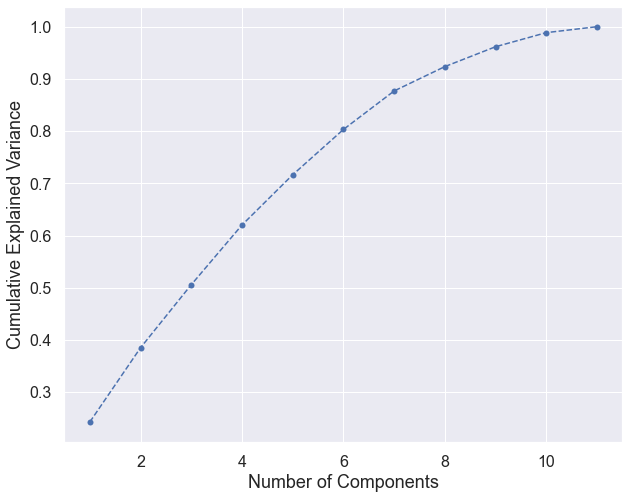

In [124]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(df_X.columns)+1), evr.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig = plt.savefig("./visualizations/cumulative_variance_plot.png")
plt.show()

In [125]:
for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print("Number of components:", n_comps)
pca = PCA(n_components=n_comps)
pca.fit(X_std)
scores_pca = pca.transform(X_std)

Number of components: 6


In [132]:
df_seg_pca = pd.concat([df_X.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_seg_pca.columns.values[(-1*n_comps):] = ["Component " + str(i+1) for i in range(n_comps)]
df_seg_pca['label'] = track_info['label']
df_seg_pca.head()

,acousticness,danceability,energy,instrumentalness,key,liveness,mode,loudness,speechiness,tempo,valence,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,label
0,0.00647,0.487,0.775,0.061400,0,0.0893,1,-5.877,0.0375,131.862,0.163,-1.275086,-0.725084,-1.923328,-2.233494,0.439471,0.095880,source
1,0.00201,0.473,0.883,0.000967,6,0.1420,1,-3.650,0.0470,115.048,0.164,-1.757170,0.837882,-1.653249,-2.224321,0.161200,0.060273,source
2,0.00287,0.743,0.766,0.456000,0,0.0917,1,-5.401,0.0326,124.993,0.625,-3.075910,-2.717368,0.629383,-0.580705,2.207282,1.926288,source
3,0.03920,0.624,0.568,0.000256,1,0.1290,1,-8.905,0.0591,91.009,0.282,-0.115540,-1.018286,-1.725853,-0.091017,0.445281,-0.210166,source
4,0.37100,0.689,0.487,0.000000,5,0.4280,0,-9.585,0.0791,97.043,0.215,1.261816,1.414784,-0.644702,0.669354,0.972729,0.544366,source


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



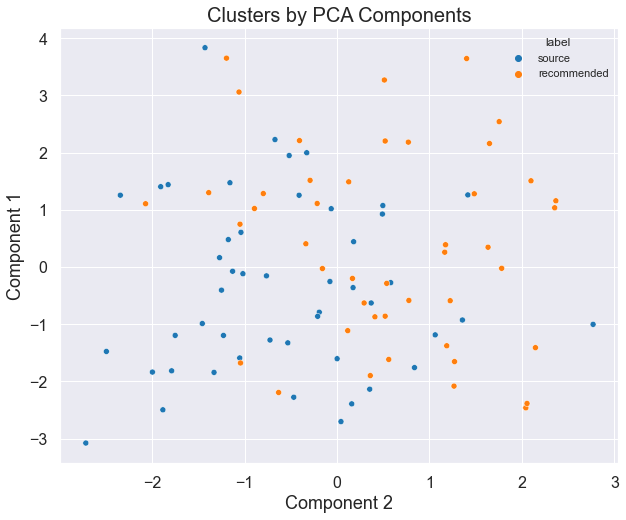

In [137]:
import plotly
x = df_seg_pca['Component 2']
y = df_seg_pca['Component 1']
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(x, y, hue=df_seg_pca['label'], palette = ['tab:blue', 'tab:orange'])
plt.title('Clusters by PCA Components', fontsize=20)
plt.xlabel("Component 2", fontsize=18)
plt.ylabel("Component 1", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
# fig.savefig("./visualizations/clusters-2d.png")

In [28]:
df['Cluster'] = df_seg_pca_kmeans['Cluster']
df

,track_name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Cluster
0,False Confidence,Noah Kahan,spotify:track:7nDFTHHwfe32a8qdp9XqPy,0.16300,0.414,0.663,0,0.1380,-7.770,0.0456,108.980,0.330,5
1,Someone Like You (feat. Joy Oladokun),Noah Kahan,spotify:track:0hiHNxqKGf3GZgVTIOAiiK,0.46800,0.614,0.526,0,0.0939,-7.492,0.0603,177.913,0.366,5
2,Hurt Somebody,Noah Kahan,spotify:track:2Zg0aB5oVQlbQE1vzQmIIY,0.34400,0.638,0.510,0,0.2120,-6.485,0.3050,114.576,0.448,2
3,Mess,Noah Kahan,spotify:track:1BlQWQgGP84r4GYUVty4Ar,0.17600,0.442,0.826,0,0.0978,-5.320,0.0775,80.848,0.601,5
4,Part of Me,Noah Kahan,spotify:track:1o5WgxPWvoVgo20DQItKOE,0.06770,0.689,0.687,0,0.0805,-7.832,0.0376,109.986,0.248,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,Put Your Hands Up,Forest Blakk,spotify:track:57X2jAov78d6K39SOWJqaJ,0.18400,0.627,0.653,4.29e-05,0.0958,-7.291,0.0476,124.999,0.388,5
2004,If You Love Her - Acoustic,Forest Blakk,spotify:track:615LwsUs7WA2KvSRRmXAUK,0.85200,0.516,0.257,0,0.1100,-11.063,0.0331,153.617,0.444,3
2005,If You Love Her - Mark McCabe Remix,Forest Blakk,spotify:track:2MaGdDg1cbXTywMf93cEZt,0.00179,0.587,0.806,1.56e-06,0.0928,-5.098,0.0344,122.971,0.404,5
2006,I Wish I Knew,Forest Blakk,spotify:track:59fi2USYlHpzOOfjlPenJI,0.64600,0.575,0.566,0,0.2440,-7.417,0.0233,107.033,0.294,3


In [29]:
def make_normalized_df(df, col_sep):
    non_features = df[df.columns[:col_sep]]
    features = df[df.columns[col_sep:]]
    norm = MinMaxScaler().fit_transform(features)
    scaled = pd.DataFrame(norm, index=df.index, columns = df.columns[col_sep:])
    return pd.concat([non_features, scaled], axis=1)

cluster_labels = df['Cluster']
orig = df.drop(columns=['Cluster'])
values_df = make_normalized_df(orig, 3)
values_df.insert(3, 'cluster', cluster_labels)
values_df.head()

,track_name,artist,track_URI,cluster,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,False Confidence,Noah Kahan,spotify:track:7nDFTHHwfe32a8qdp9XqPy,5,0.166493,0.264865,0.659292,0.0,0.117771,0.710385,0.028096,0.372869,0.311724
1,Someone Like You (feat. Joy Oladokun),Noah Kahan,spotify:track:0hiHNxqKGf3GZgVTIOAiiK,5,0.478037,0.535135,0.516983,0.0,0.071399,0.721833,0.046617,0.814858,0.349611
2,Hurt Somebody,Noah Kahan,spotify:track:2Zg0aB5oVQlbQE1vzQmIIY,2,0.351376,0.567568,0.500364,0.0,0.195584,0.763301,0.354920,0.408750,0.435908
3,Mess,Noah Kahan,spotify:track:1BlQWQgGP84r4GYUVty4Ar,5,0.179772,0.302703,0.828607,0.0,0.075499,0.811275,0.068288,0.192490,0.596927
4,Part of Me,Noah Kahan,spotify:track:1o5WgxPWvoVgo20DQItKOE,5,0.069149,0.636486,0.684221,0.0,0.057308,0.707832,0.018017,0.379319,0.225426


In [34]:
fig = go.Figure()

angles = list(values_df.columns[4:])
angles.append(angles[0])

layoutdict = dict(
            radialaxis=dict(
            visible=True,
            range=[0, 1]
            ))

for i in range(n_clusters):
    subset = values_df[values_df['cluster'] == i]
    data = [np.mean(subset[col]) for col in subset.columns[4:]]
    data.append(data[0])
    fig.add_trace(go.Scatterpolar(
        r=data,
        theta=angles,
        fill='toself',
        name="Cluster " + str(i)))
    
fig.update_layout(
        polar=layoutdict,
        showlegend=True
        )
fig.show()
#     fig.write_image('./visualizations/cluster' + str(i) + '.png')

In [ ]:
sp = spotipy.Spotify(auth=get_token('user-read-recently-played'))
recent_track_names = [x['track']['name'] for x in sp.current_user_recently_played()['items']]
recent_tracks = [x['track']['uri'] for x in sp.current_user_recently_played()['items']]
recent_track_names